In [21]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams.update({'font.size': 26})

import sys
sys.path.append("/home/icb/sergey.vilov/workspace/MLM/utils") 

from misc import pearson_r, get_best_models, highlight_ns, model_alias, model_bar_colors, dna_models

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
project_dir = '/lustre/groups/epigenereg01/workspace/projects/vale/mlm/'

## Combine regression output

In [3]:
models = ['DNABERT','DNBT-3UTR-RNA','DNABERT2','DNABERT2-ZOO','DNBT2-3UTR-RNA','NT-MS-v2-100M',
         'NT-3UTR-RNA','STSP-3UTR-RNA','STSP-3UTR-RNA-SA','STSP-3UTR-DNA','STSP-3UTR-RNA-HS','5-mers Siegel et al., 2022']

In [4]:
res = []

for regressor in ('Ridge','SVR'):
    print(regressor)
    results_dir = project_dir + f'mpra/siegel_2022/predictions/onlyref_0/{regressor}/'
    for cell_line in ('Jurkat', 'Beas2B'):
        mpra_df = pd.read_csv(project_dir + f'mpra/siegel_2022/preprocessing/' + cell_line + '.tsv', sep='\t')
        for response in ('stability', 'steady_state'):
            for model in models:
                res_tsv = results_dir + f'{cell_line}-{response}-{model_alias[model]}.tsv'
                if os.path.isfile(res_tsv):
                    df = pd.read_csv(res_tsv, sep='\t')
                    df['model'] = model
                    df['response'] = response
                    df['cell_line'] = cell_line
                    df['regressor'] = regressor
                    res.append(df)

res = pd.concat(res)
res = res.rename(columns={'Expression':'y_true','group':'fold'})
res = res[['fold','SNP','ids','strand',
           'regressor','cell_line','model','response','y_true','y_pred']]

Ridge
SVR


In [5]:
res.loc[res.model.isin(dna_models),'fasta_file'] = 'mpra/siegel_2022/fasta/variants_dna_fwd.fa'
res.loc[~res.model.isin(dna_models),'fasta_file'] = 'mpra/siegel_2022/fasta/variants_rna.fa'

In [6]:
#number of targets

res.groupby(['regressor','cell_line','response']).model.count()//res.model.nunique()

regressor  cell_line  response    
Ridge      Beas2B     stability        4058
                      steady_state     8573
           Jurkat     stability       13559
                      steady_state    14955
SVR        Beas2B     stability        4058
                      steady_state     8573
           Jurkat     stability       13559
                      steady_state    14955
Name: model, dtype: int64

In [7]:
res.to_csv(project_dir + 'all_scores/mpra_siegel_2022.tsv.gz',sep='\t',index=None)

## Compute summary statistics

In [18]:
models = ['DNABERT','DNBT-3UTR-RNA','DNABERT2','DNABERT2-ZOO','DNBT2-3UTR-RNA','NT-MS-v2-100M',
         'NT-3UTR-RNA','STSP-3UTR-RNA','STSP-3UTR-RNA-HS','STSP-3UTR-DNA','5-mers Siegel et al., 2022']

In [19]:
res = pd.read_csv(project_dir + 'all_scores/mpra_siegel_2022.tsv.gz',sep='\t')

res = res[res.model.isin(models)]

In [22]:
scores_df = res.groupby(['regressor','model','cell_line','response']).apply(lambda x:pearson_r(x.y_true,x.y_pred,compute_CI=True),include_groups=False).rename('pearson_r').reset_index()
scores_df.pearson_r = scores_df.pearson_r.apply(lambda x: (round(x[0],2),round(x[1],2)))

best_models = scores_df.set_index('model').groupby(['regressor','cell_line','response']).pearson_r.apply(get_best_models)
scores_df = scores_df.pivot(index=['regressor','model'],columns=['cell_line','response']).droplevel(0,axis=1)
scores_df = scores_df.map(lambda x: f'{x[0]:.2f}±{x[1]:.2f}' if isinstance(x,tuple) else 'none')

In [23]:
scores_df.loc['Ridge'].loc[models].style.apply(lambda x: highlight_ns(x, best_models.loc['Ridge']))

In [24]:
scores_df.loc['SVR'].loc[models].style.apply(lambda x: highlight_ns(x, best_models.loc['SVR']))

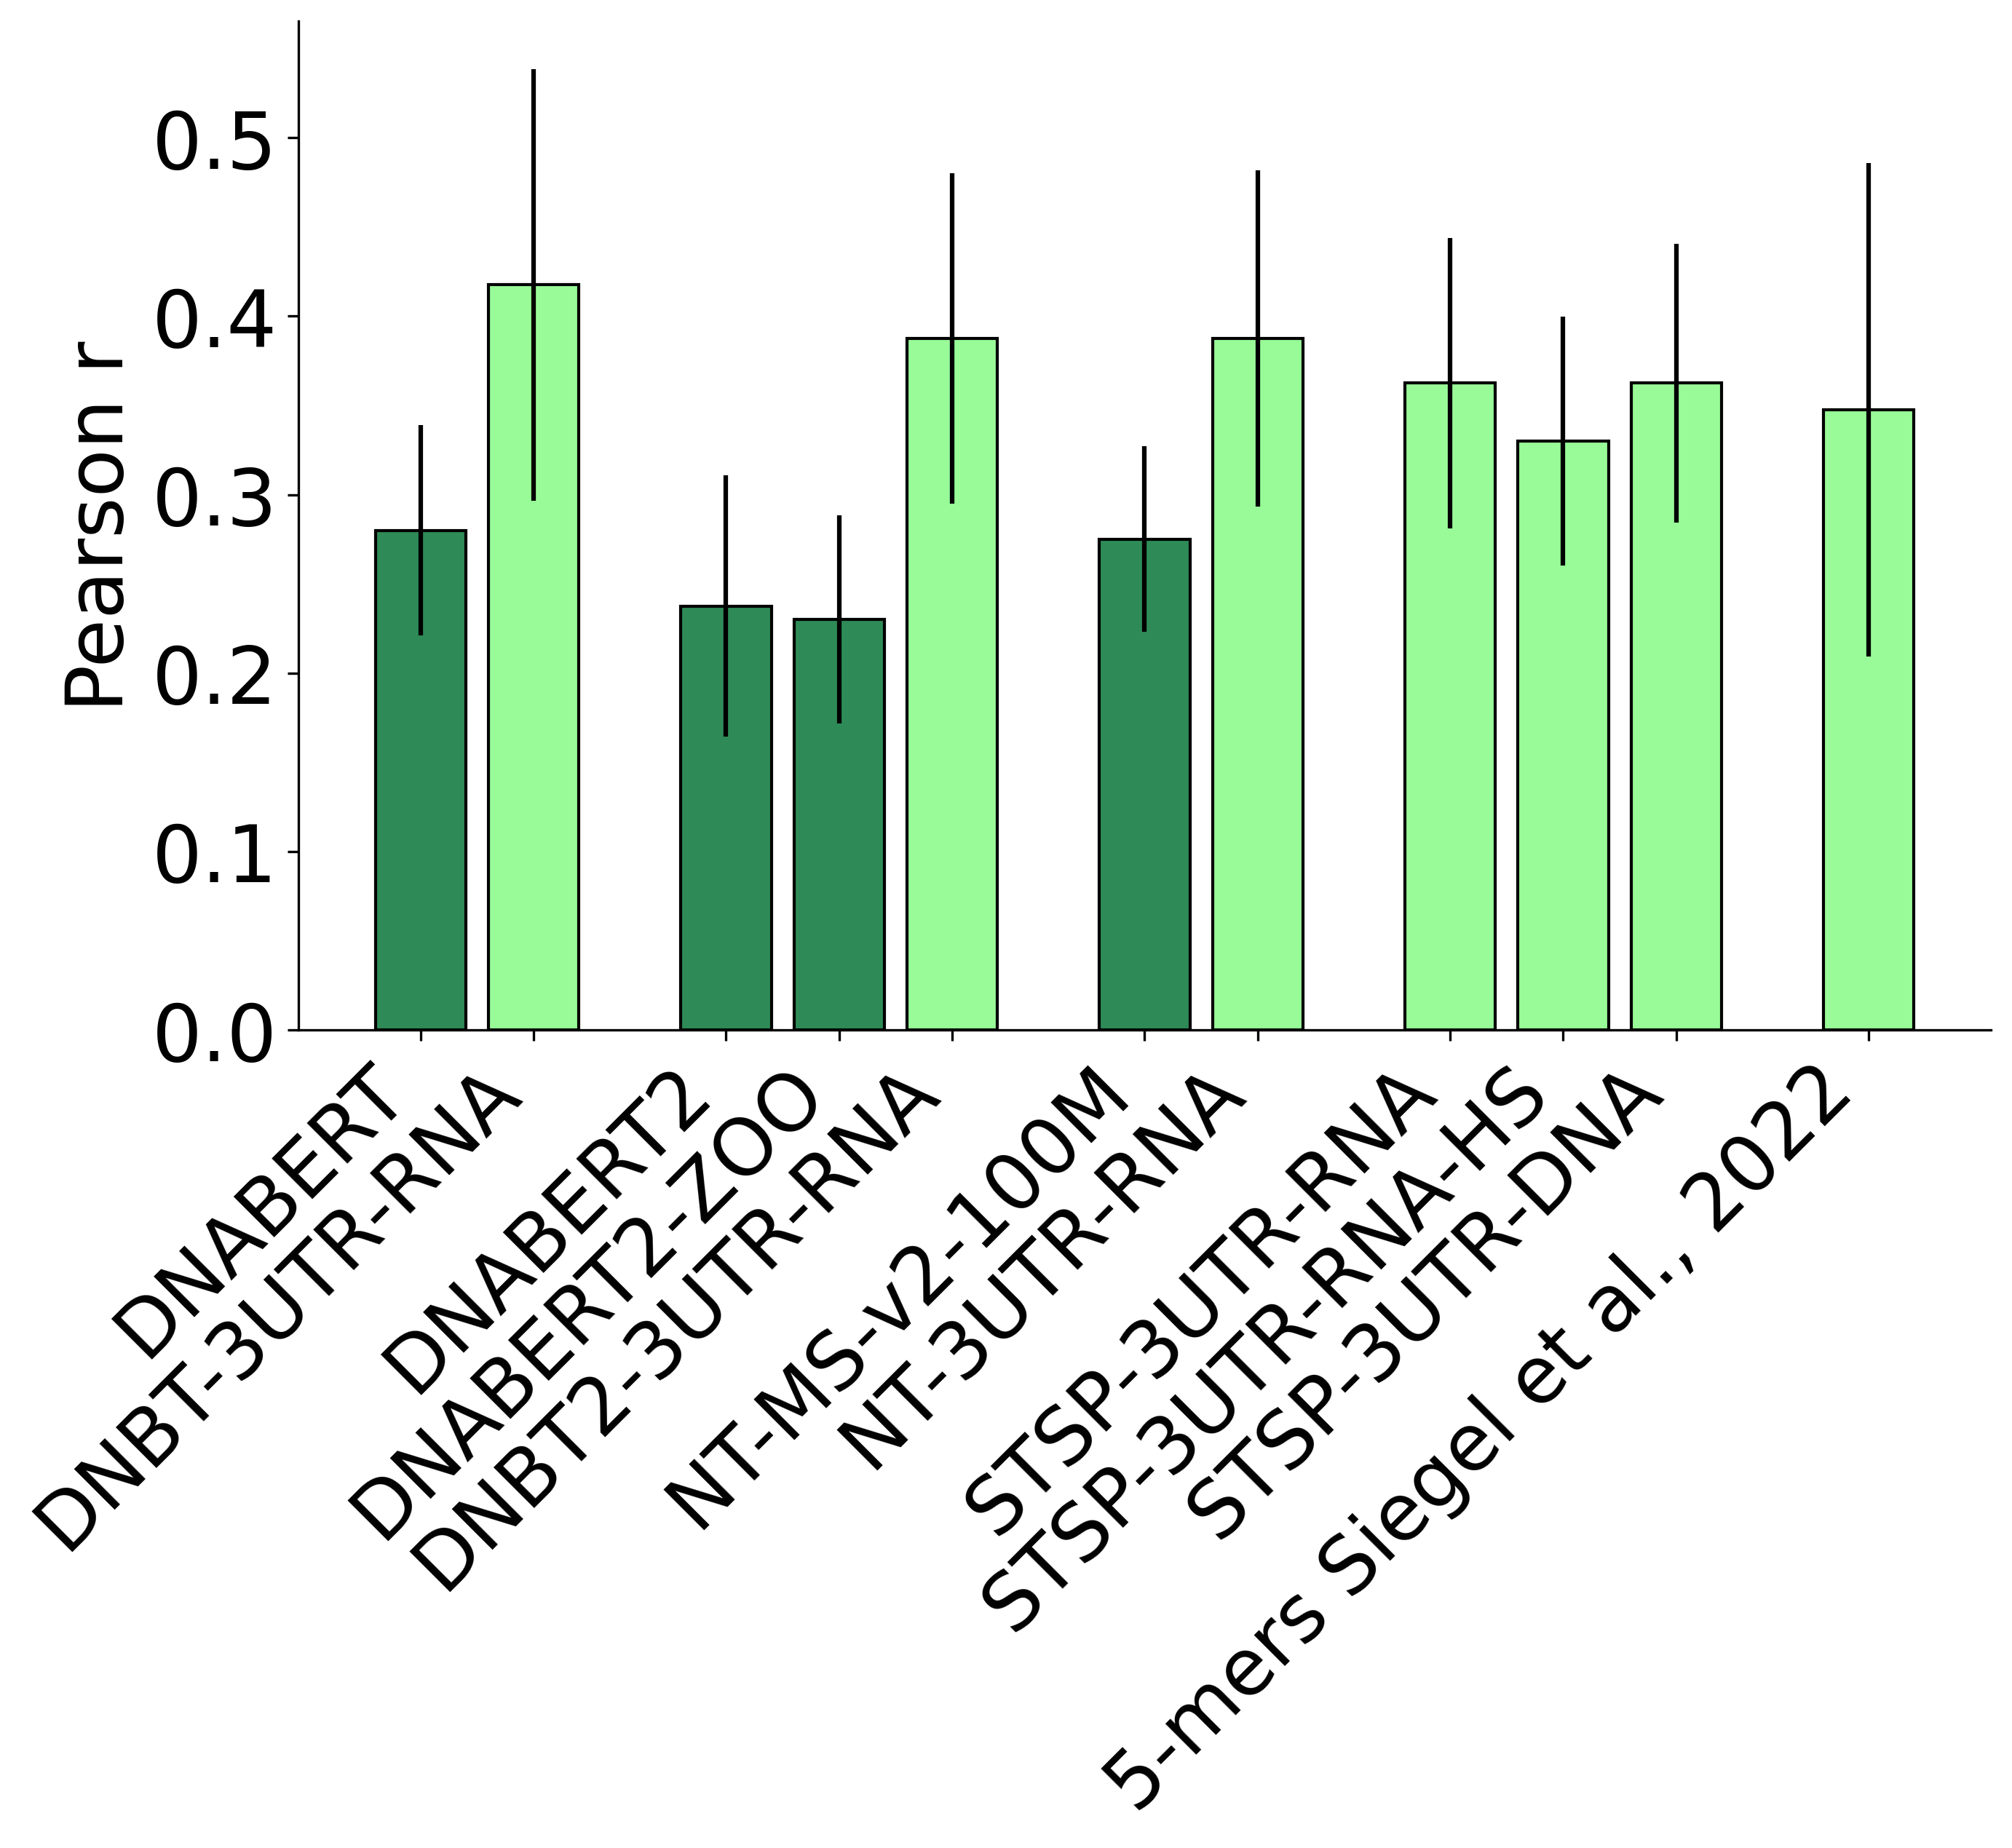

In [25]:
df = scores_df.loc['SVR'].loc[models].map(lambda x:float(x.split('±')[0]))

fig, ax = plt.subplots(dpi=300, figsize=(10,6))

offset = 0

xticks = []
for idx, (model, corr) in enumerate(df.iterrows()):
    if model in ('DNABERT2','NT-MS-v2-100M','STSP-3UTR-RNA','5-mers Siegel et al., 2022'):
        offset+=0.7
    ax.bar(offset+idx, corr.mean(), yerr=corr.std(), color=model_bar_colors[model], edgecolor='black')
    xticks.append(offset+idx)
    
ax.set_xticks(xticks, df.index, rotation=45, ha="right");

ax.set_ylabel('Pearson r')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

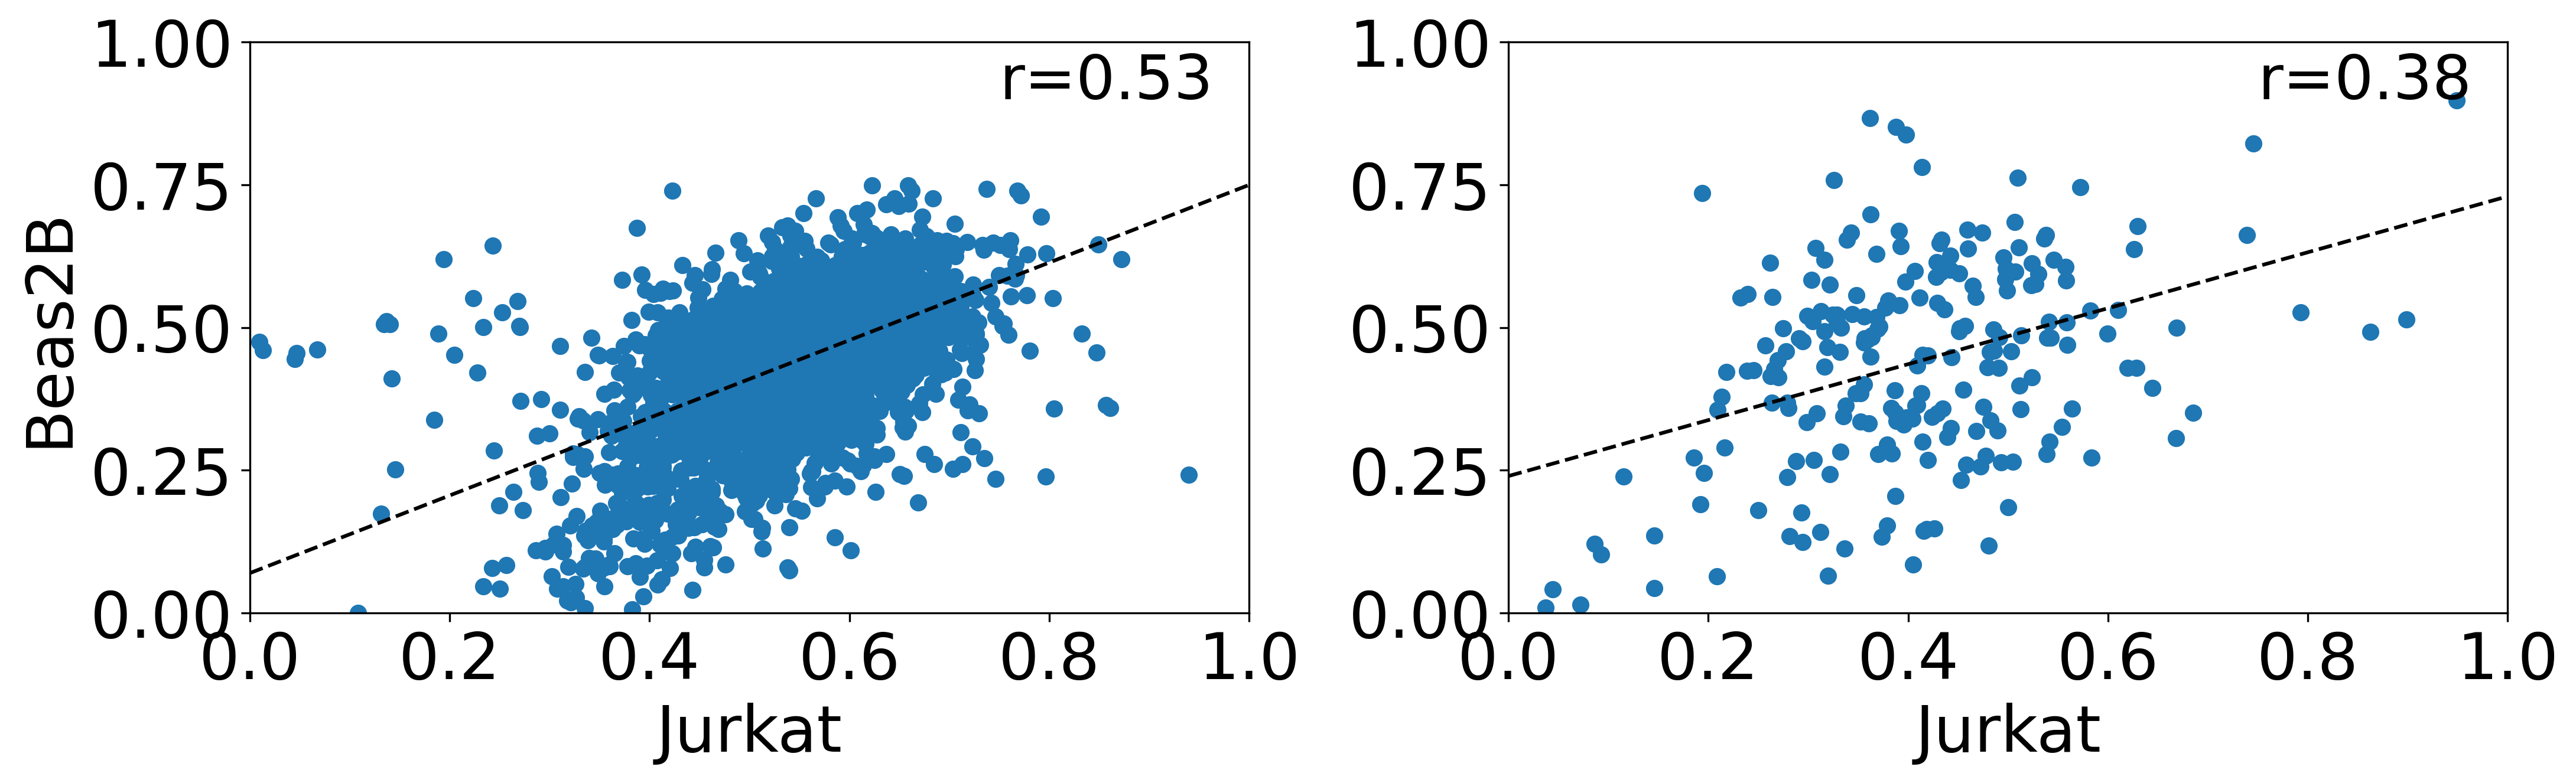

In [26]:
fig, axes = plt.subplots(1,2, figsize=(15,5),dpi=300)

ax_idx = 0

for response,ax in zip(('stability','steady_state'),axes):

    df = res.drop_duplicates(['cell_line','ids'])
    df = pd.pivot(df.loc[df.response==response,['cell_line','y_true','ids']],index='ids',columns='cell_line')
    df = df.dropna().droplevel(0,axis=1)
    
    x, y = df[['Jurkat','Beas2B']].values.T
    
    ax.scatter(x,y)

    pearson_r = np.corrcoef(x,y)[0,1]

    b,a = np.polynomial.polynomial.polyfit(x,y, 1)
    b,a = round(b,2), round(a,2)
    x = np.linspace(0,1)
    ax.plot(x, a*x+b, '--', color='k')

    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    
    ax.set_xlabel('Jurkat')
    
    if ax_idx==0:
        ax.set_ylabel('Beas2B')

    ax.text(0.75, 0.9, f'r={pearson_r:.2f}', zorder=1, fontsize=25)

    ax_idx += 1
    
fig.tight_layout()